## For inference not needed for now

In [1]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader

# Get the debiased data, import libs, and show some samples

In [2]:
!cp /content/drive/MyDrive/LUMA/bias_detection_on_restructured_prompts.tsv ./dibiased_data.tsv
!cp /content/drive/MyDrive/LUMA/binary_classification_results.csv ./binary_classification_results.csv
!cp /content/drive/MyDrive/LUMA/multiclass_bias.csv ./multiclass_bias.csv
!cp /content/drive/MyDrive/LUMA/bias_detection.tsv ./bias_detection.tsv

In [3]:
import pandas as pd
import random
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [4]:
debiased_data = pd.read_csv('dibiased_data.tsv', sep='\t', index_col=0)
binary_classification_results = pd.read_csv('binary_classification_results.csv')
multiclass_bias = pd.read_csv('multiclass_bias.csv')
bias_detection = pd.read_csv('bias_detection.tsv', sep='\t', index_col=0)

In [5]:
print(f'lenght of debiased_data: {len(debiased_data)}')
print(f'lenght of binary_classification_results: {len(binary_classification_results)}')
print(f'lenght of multiclass_bias: {len(multiclass_bias)}')

lenght of debiased_data: 44346
lenght of binary_classification_results: 62875
lenght of multiclass_bias: 20170


In [6]:
debiased_data.bias.unique()

array(['no_bias', 'gender_bias', 'none', 'cultural_bias',
       'historical_bias', 'religious_bias',
       'stereotypical_appearance_bias', 'mythical_bias', 'religous_bias',
       'political_bias', 'diversity_bias', 'progressive_bias',
       'mythology_bias', 'stereotypical_bias', 'fictional_bias',
       'economic_bias', 'hate_speech', 'imposter_bias',
       'freedom_of_speech_bias', 'racial_bias', 'father_bias',
       'mythological_bias', 'magical_bias', 'supernatural_bias',
       'fictional_character_bias', 'genealogical_bias', 'noble_bias',
       'colonial_bias', 'celebrity_bias', 'knowledge_bias',
       'professional_bias', 'content_bias', 'ego_bias', 'name_bias',
       'character_bias', 'family_bias', 'fantasy_bias',
       'stereotypical_villain', 'philosophical_bias', 'ethical_bias',
       'existential_bias', 'authority_bias', 'political_influence_bias',
       'positive_fatherhood_bias', 'humility_bias', 'metaphorical_bias',
       'humanism_bias', 'moral_bias', 'fi

Use binary classification instead

In [7]:
debiased_data['bias'] = debiased_data['bias'].replace({'no_bias': 'Non-biased', 'none': 'Non-biased'})
debiased_data['bias'] = debiased_data['bias'].apply(lambda x: 'biased' if x != 'Non-biased' else x)

In [8]:
bias_detection['bias'] = bias_detection['bias'].replace({'no_bias': 'Non-biased', 'none': 'Non-biased'})
bias_detection['bias'] = bias_detection['bias'].apply(lambda x: 'biased' if x != 'Non-biased' else x)

In [9]:
bias_detection.bias.unique()

array(['Non-biased', 'biased'], dtype=object)

In [10]:
debiased_data.bias.unique()

array(['Non-biased', 'biased'], dtype=object)

In [11]:
idx = random.randint(0, len(debiased_data))
print(f'sample {idx} \nText: {debiased_data.loc[idx].text} \nLabel: {debiased_data.loc[idx].bias}')

sample 18684 
Text: A woman scientist named Dr. Maria Lopez is conducting an experiment to invent a machine that can diagnose diseases accurately. Maria's groundbreaking research has led to the development of a revolutionary medical device. 
Label: biased


In [12]:
merged_clean = pd.merge(
    debiased_data,
    binary_classification_results,
    on=['text', 'label'],
    how='inner'
)

# Keep only the required columns
final_clean = merged_clean[['text', 'label', 'bias', 'results']]
final_clean.rename(columns={'bias': 'bias_label_a'}, inplace=True)

<ipython-input-12-0793571e8a41>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_clean.rename(columns={'bias': 'bias_label_a'}, inplace=True)


In [13]:
merged_dirty = pd.merge(
    bias_detection,
    binary_classification_results,
    on=['text', 'label'],
    how='inner'
)

# Keep only the required columns
final_dirty = merged_dirty[['text', 'label', 'bias', 'results']]
final_dirty.rename(columns={'bias': 'bias_label_a'}, inplace=True)

<ipython-input-13-189016b28b0b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dirty.rename(columns={'bias': 'bias_label_a'}, inplace=True)


In [14]:
final_dirty.label.unique()

array(['ship', 'fish', 'television', 'chair', 'house', 'train', 'snake',
       'bicycle', 'sea', 'forest', 'table', 'plain', 'cat', 'camel',
       'tank', 'telephone', 'cloud', 'fox', 'castle', 'lion', 'mountain',
       'road', 'bee', 'bridge', 'horse', 'whale', 'baby', 'truck', 'lamp',
       'bird', 'mouse', 'frog', 'bear', 'roses', 'bus', 'elephant',
       'palm', 'pine', 'rabbit', 'ray', 'dog', 'cattle', 'oak', 'clock',
       'bed', 'wolf'], dtype=object)

In [15]:
def get_bias_label(data, threshold = 0.9):
    # Extract label and score into separate columns
    data['bias_label_b'] = data['results'].apply(lambda x: 'Biased' if eval(x)['score'] > threshold else 'Non-biased')
    return data

In [16]:
final_clean = get_bias_label(final_clean, threshold = 0.98).drop(columns=['results'])

<ipython-input-15-0c4fe7a47bc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bias_label_b'] = data['results'].apply(lambda x: 'Biased' if eval(x)['score'] > threshold else 'Non-biased')


In [17]:
final_clean.bias_label_a.unique(), final_clean.bias_label_b.unique()

(array(['Non-biased'], dtype=object),
 array(['Non-biased', 'Biased'], dtype=object))

In [18]:
final_dirty = get_bias_label(final_dirty, threshold = 0.98).drop(columns=['results'])

<ipython-input-15-0c4fe7a47bc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bias_label_b'] = data['results'].apply(lambda x: 'Biased' if eval(x)['score'] > threshold else 'Non-biased')


In [19]:
final_dirty.bias_label_a.unique(), final_dirty.bias_label_b.unique()

(array(['Non-biased', 'biased'], dtype=object),
 array(['Non-biased', 'Biased'], dtype=object))

In [20]:
def analyze_model_predictions(df):
    """
    Analyze and compare predictions between two models.

    Parameters:
    df (pandas.DataFrame): DataFrame containing 'label', 'bias_label_a', and 'bias_label_b'

    Returns:
    dict: Dictionary containing various analysis metrics
    """
    # Calculate overall agreement
    agreement = (df['bias_label_a'] == df['bias_label_b']).mean() * 100

    # Create confusion matrix between models
    confusion_matrix = pd.crosstab(
        df['bias_label_a'],
        df['bias_label_b'],
        margins=True
    )

    # Agreement by category/label
    agreement_by_label = df.groupby('label').apply(
        lambda x: (x['bias_label_a'] == x['bias_label_b']).mean() * 100
    ).to_dict()

    # Distribution of predictions for each model by label
    distribution_a = df.groupby(['label', 'bias_label_a']).size().unstack(fill_value=0)
    distribution_b = df.groupby(['label', 'bias_label_b']).size().unstack(fill_value=0)

    # Calculate disagreement cases
    disagreements = df[df['bias_label_a'] != df['bias_label_b']]

    return {
        'overall_agreement': agreement,
        'confusion_matrix': confusion_matrix,
        'agreement_by_label': agreement_by_label,
        'distribution_a': distribution_a,
        'distribution_b': distribution_b,
        'disagreements': disagreements
    }

def visualize_comparisons(analysis_results):
    """
    Create visualizations for model comparison results

    Parameters:
    analysis_results (dict): Output from analyze_model_predictions
    """
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix Heatmap
    sns.heatmap(
        analysis_results['confusion_matrix'].iloc[:-1, :-1],
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Confusion Matrix between Model A and B')

    # Agreement by Label Bar Plot
    agreement_data = pd.Series(analysis_results['agreement_by_label'])
    agreement_data.plot(
        kind='bar',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Agreement Percentage by Label')
    axes[0, 1].set_ylabel('Agreement (%)')

    # Distribution plots for each model
    analysis_results['distribution_a'].plot(
        kind='bar',
        stacked=True,
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('Distribution of Predictions - Model A')
    axes[1, 0].set_ylabel('Count')

    analysis_results['distribution_b'].plot(
        kind='bar',
        stacked=True,
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('Distribution of Predictions - Model B')
    axes[1, 1].set_ylabel('Count')

    plt.tight_layout()
    plt.title('Model Comparison Analysis ')
    return fig

<ipython-input-20-88534966bd34>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_by_label = df.groupby('label').apply(


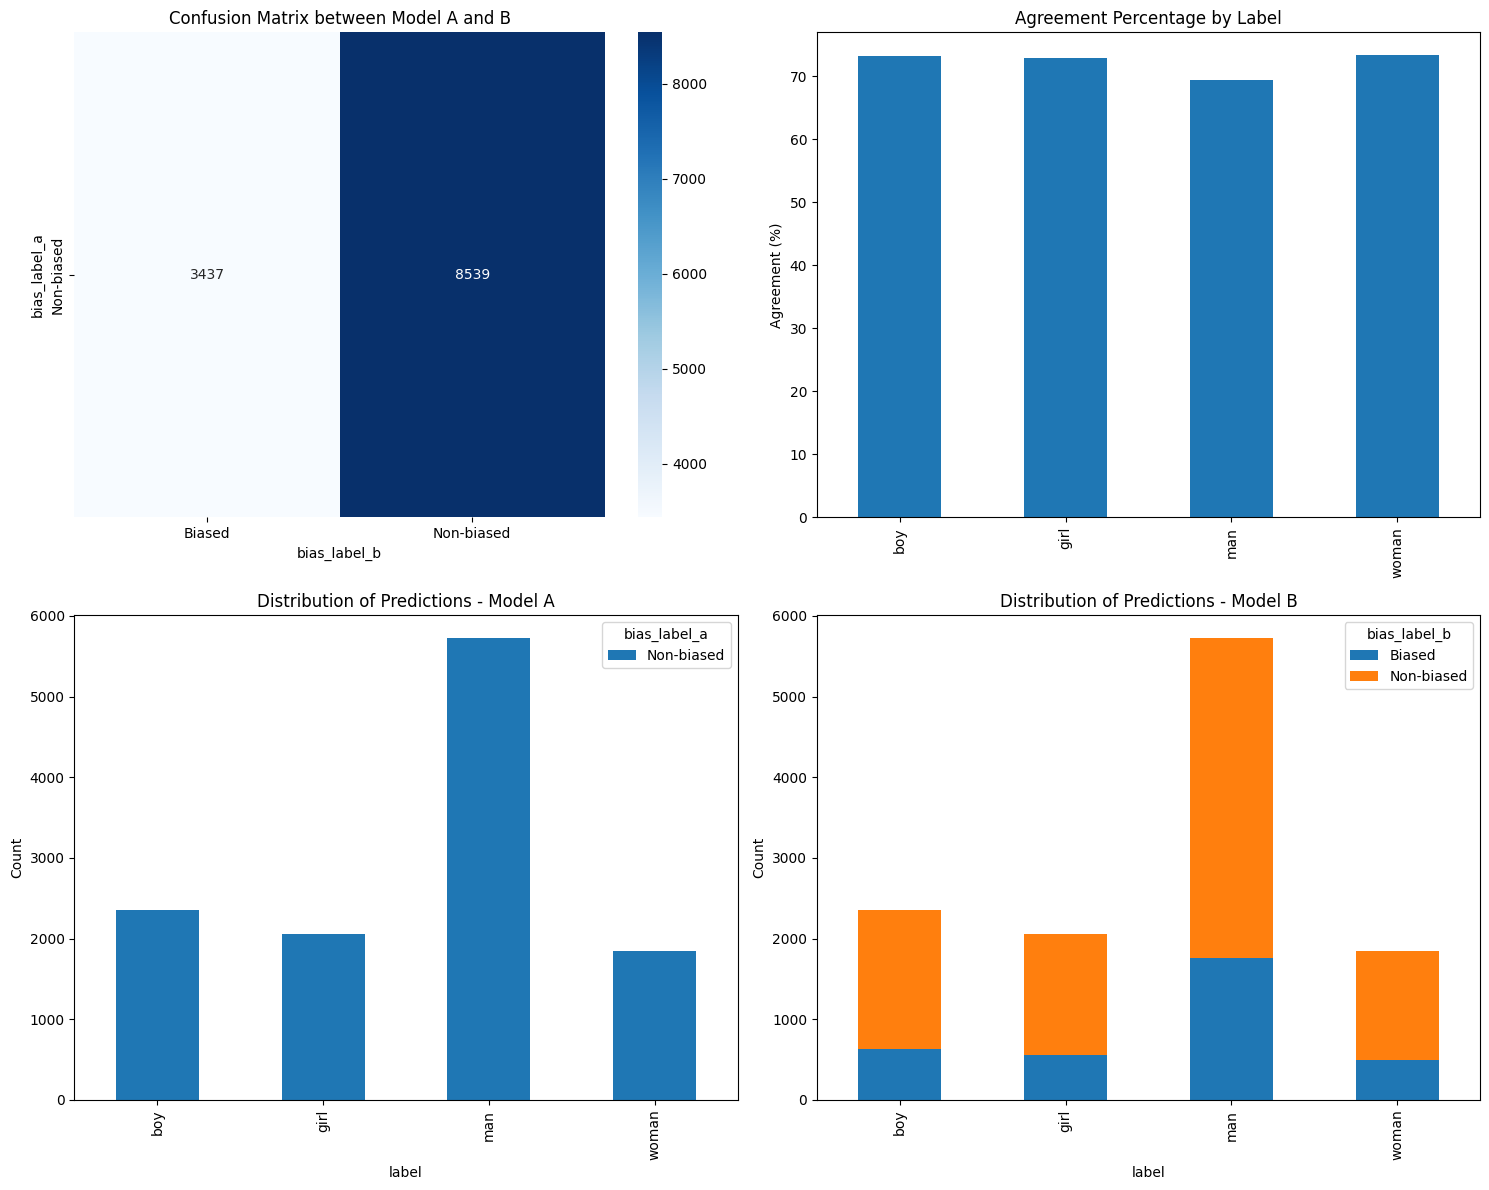

In [21]:
results = analyze_model_predictions(final_clean)
fig = visualize_comparisons(results)
plt.show()

<ipython-input-20-88534966bd34>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agreement_by_label = df.groupby('label').apply(


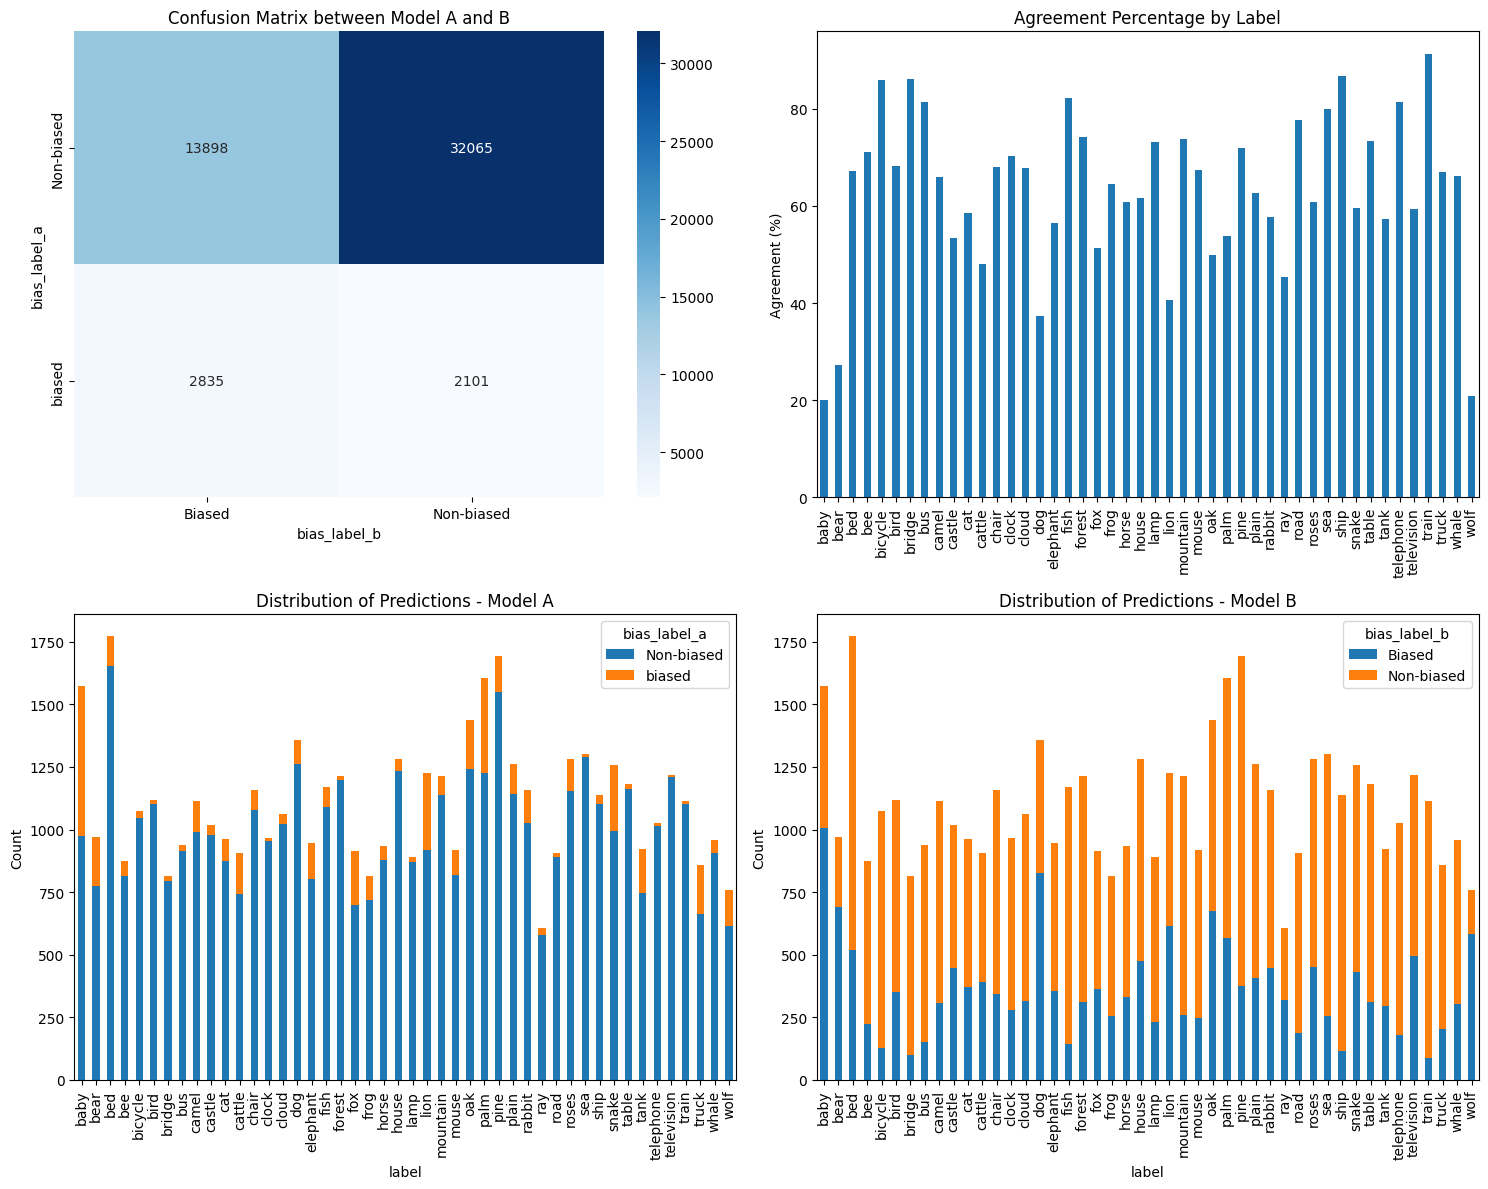

In [22]:
results = analyze_model_predictions(final_dirty)
fig = visualize_comparisons(results)
plt.show()